# Models > Neural Networks (MLP)

<div class="alert alert-info">Estimate and tune a Multi-Layer Perceptron model for reg_nnression</div>

In [1]:
# install latest version of pyrsm
# make sure to add --user
# %pip install --user pyrsm --upgrade

In [2]:
import os

import matplotlib as mpl
import numpy as np
import polars as pl
from sklearn.model_selection import GridSearchCV, KFold

import pyrsm as rsm

# increase plot resolution
mpl.rcParams["figure.dpi"] = 100

In [3]:
rsm.__version__

'1.7.0'

In [4]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

### Example 1: Catalog sales

We have access to data from a company selling men's and women's apparel through mail-order catalogs (dataset `catalog`). The company maintains a database on past and current customers' value and characteristics. Value is determined as the total \$ sales to the customer in the last year.

The catalog company is interested in redesigning their Customer Relationship Management (CRM) strategy. We will proceed in two steps:

1. Estimate a regression model using last year's sales total. Response variable: sales total for each of the 200 households; Explanatory variables: household income (measured in thousands of dollars), size of household, and age of the household head.
2. Interpret each of the estimated coefficients. Also provide a statistical evaluation of the model as a whole.
3. Which explanatory variables are significant predictors of customer value (use a 95% confidence level)?


In [5]:
# load example data from the pyrsm library
catalog, catalog_description = rsm.load_data(pkg="model", name="catalog")
catalog

id,Sales,Income,HH_size,Age
i32,f64,f64,i32,f64
1,178.63,93.0,4,55.0
2,338.59,79.0,5,35.0
3,210.26,70.0,4,64.0
4,378.64,95.0,2,39.0
5,227.09,119.0,2,43.0
…,…,…,…,…
196,234.85,42.0,2,38.0
197,138.2,94.0,2,58.0
198,340.74,88.0,2,35.0


In [6]:
# format the data description
rsm.md(catalog_description)

## Catalog sales

### Description

Data from a company selling men's and women's apparel through mail-order catalogs. The company maintains a database on past and current customers' value and characteristics. Value is determine as the total $ sales to the customer in the last year. The data are a random sample of 200 customers from the company's database.

### Variables

A data frame with 200 observations on 4 variables

- id = Customer id
- Sales =	Total sales (in $) to a household in the past year
- Income = Household income ($1000) 
- HH.size = Size of the household (# of people) 
- Age = Age of the head of the household

In [7]:
reg_nn = rsm.model.mlp(
    {"catalog": catalog}, rvar="Sales", evar=["Income", "HH_size", "Age"], mod_type="regression"
)

In [8]:
reg_nn.summary()

Multi-layer Perceptron (NN)
Data                 : catalog
Response variable    : Sales
Explanatory variables: Income, HH_size, Age
Model type           : regression
Nr. of features      : (3, 3)
Nr. of weights       : 26
Nr. of observations  : 200
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
    n     r2    mse    mae
  200  0.483  0.517  0.572

Raw data             :
shape: (5, 3)
┌────────┬─────────┬──────┐
│ Income ┆ HH_size ┆ Age  │
│ ---    ┆ ---     ┆ ---  │
│ f64    ┆ i32     ┆ f64  │
╞════════╪═════════╪══════╡
│ 93.0   ┆ 4       ┆ 55.0 │
│ 79.0   ┆ 5       ┆ 35.0 │
│ 70.0   ┆ 4       ┆ 64.0 │
│ 95.0   ┆ 2       ┆ 39.0 │
│ 119.0  ┆ 2       ┆ 43.0 │
└────────┴─────────┴──────┘

Estimation data      :
shape: (5, 3)
┌──────────┬───────────┬───────────┐
│ Income   ┆ HH_size  

### Example 2: Ideal data for regression

The data `ideal` contains simulated data that is very useful to demonstrate what data for, and residuals from, a regression should ideally look like. The data has 1,000 observations on 4 variables. `y` is the response variable and `x1`, `x2`, and `x3` are explanatory variables. The plots shown below can be used as a bench mark for regressions on real world data

In [9]:
ideal, ideal_description = rsm.load_data(pkg="model", name="ideal")
ideal

y,x1,x2,x3
f64,f64,f64,f64
-5.975681,0.1528409,5.011979,3.155253
0.9587033,0.1909307,3.233194,5.354473
-2.03179,0.5882474,4.891027,5.832465
-7.318411,0.2684134,7.682724,6.600717
-2.746885,0.6724028,5.358413,3.147829
…,…,…,…
-14.56506,0.1226219,10.43934,7.018642
-2.374663,0.875633,5.491546,5.039407
-4.267488,0.517993,8.487617,6.668247


In [10]:
rsm.md(ideal_description)

## 'Ideal' data for regression

### Description

Simulated data set used to illustrate evaluation of regression residuals.  

### Variables

A data frame with 1000 observations on 4 variables (y, x1, x2, and x3)

`y`, `x2`, and `x3` appear (roughly) normally distributed whereas `x1` appears (roughly) uniformly distributed. There are no indication of outliers or severely skewed distributions.

In [11]:
reg_nn = rsm.model.mlp({"ideal": ideal}, rvar="y", evar=["x1", "x2", "x3"], mod_type="regression")

In [12]:
reg_nn.summary()

Multi-layer Perceptron (NN)
Data                 : ideal
Response variable    : y
Explanatory variables: x1, x2, x3
Model type           : regression
Nr. of features      : (3, 3)
Nr. of weights       : 26
Nr. of observations  : 1,000
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
     n     r2    mse    mae
  1000  0.809  0.191  0.349

Raw data             :
shape: (5, 3)
┌───────────┬──────────┬──────────┐
│ x1        ┆ x2       ┆ x3       │
│ ---       ┆ ---      ┆ ---      │
│ f64       ┆ f64      ┆ f64      │
╞═══════════╪══════════╪══════════╡
│ 0.1528409 ┆ 5.011979 ┆ 3.155253 │
│ 0.1909307 ┆ 3.233194 ┆ 5.354473 │
│ 0.5882474 ┆ 4.891027 ┆ 5.832465 │
│ 0.2684134 ┆ 7.682724 ┆ 6.600717 │
│ 0.6724028 ┆ 5.358413 ┆ 3.147829 │
└───────────┴──────────┴──────────┘

Estimation data     

The dashboard of six residual plots looks excellent, as we might expect for these data. True values and predicted values from the regression form a straight line with random scatter, i.e., as the actual values of the response variable go up, so do the predicted values from the model. The residuals (i.e., the differences between the values of the response variable data and the values predicted by the regression) show no pattern and are randomly scattered around a horizontal line. Any pattern would suggest that the model is better (or worse) at predicting some parts of the data compared to others. If a pattern were visible in the Residual vs Row order plot we might be concerned about auto-correlation. Again, the residuals are nicely scattered about a horizontal axis. Note that auto-correlation is a problem we are really only concerned about when we have time-series data. The Q-Q plot shows a nice straight and diagonal line, evidence that the residuals are normally distributed. This conclusion is confirmed by the histogram of the residuals and the density plot of the residuals (green) versus the theoretical density of a normally distributed variable (blue line).

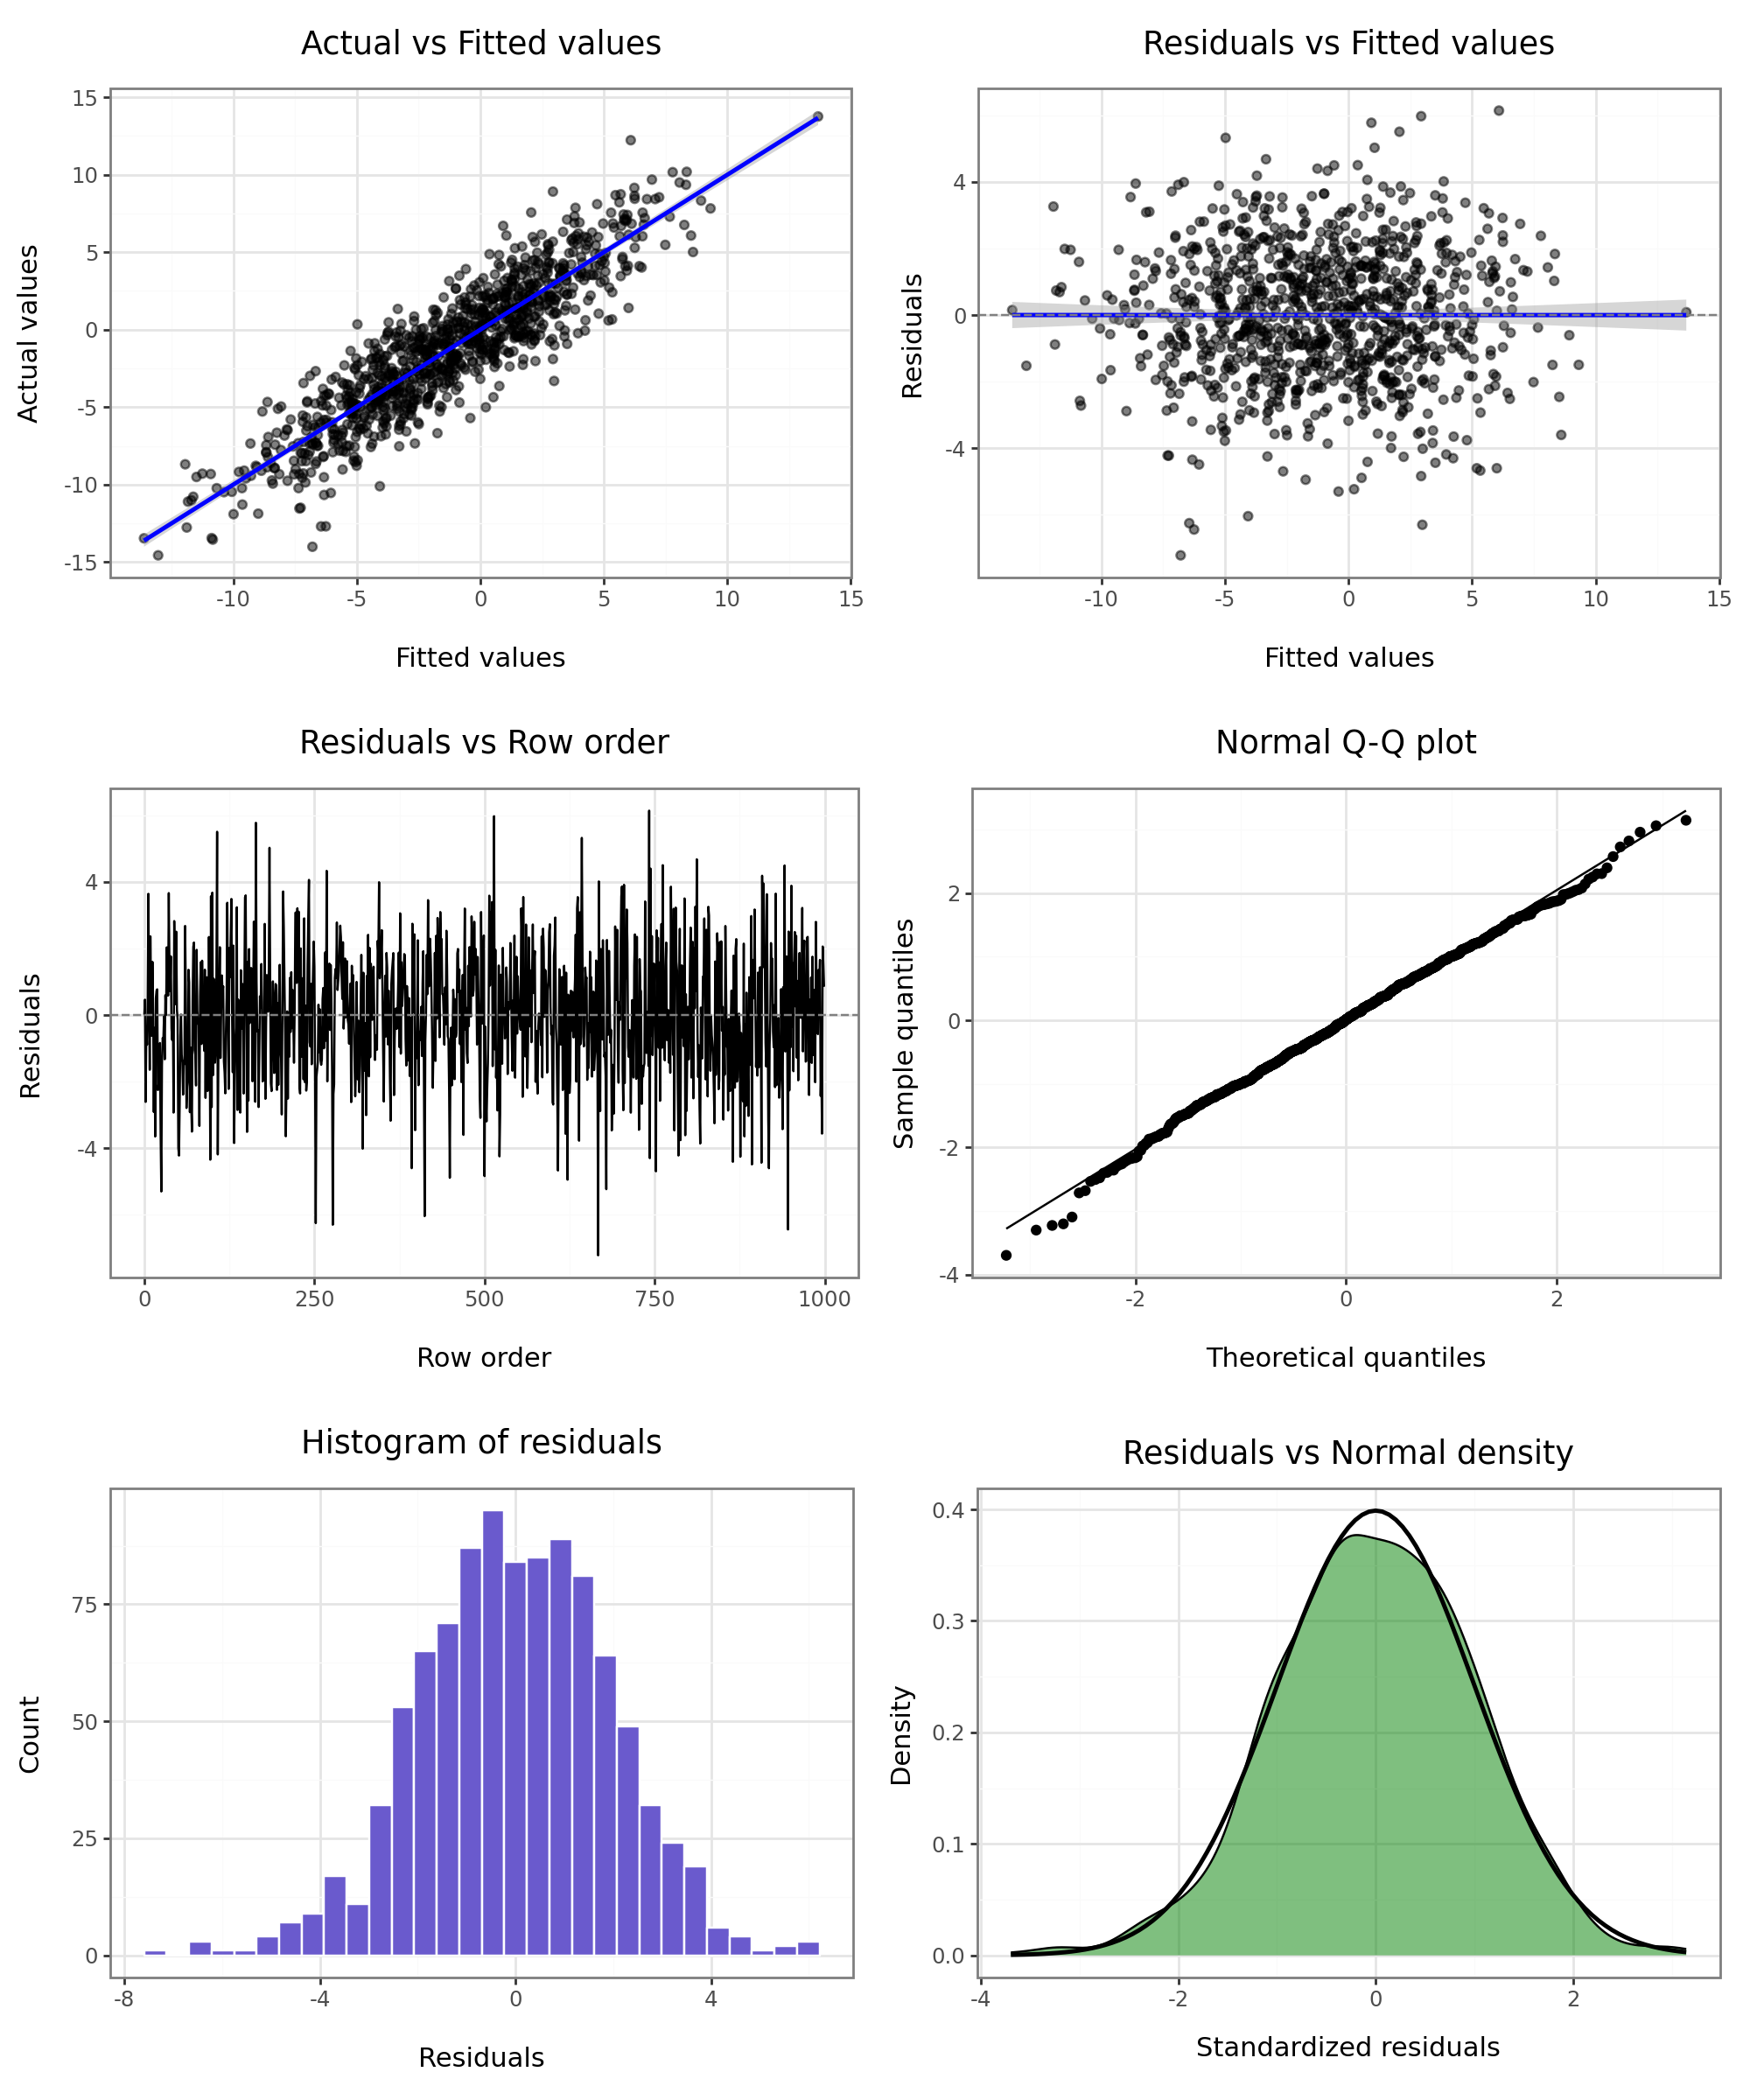

In [13]:
reg_nn.plot("dashboard")

### Example 3: Linear or log-log regression?

Both linear and log-log regressions are commonly applied to business data. In this example we will look for evidence in the data and residuals that may suggest which model specification is  appropriate for the available data.

In [14]:
diamonds, diamonds_description = rsm.load_data(pkg="data", name="diamonds")
diamonds

price,carat,clarity,cut,color,depth,table,x,y,z,date
i32,f64,cat,cat,cat,f64,f64,f64,f64,f64,date
580,0.32,"""VS1""","""Ideal""","""H""",61.0,56.0,4.43,4.45,2.71,2012-02-26
650,0.34,"""SI1""","""Very Good""","""G""",63.4,57.0,4.45,4.42,2.81,2012-02-26
630,0.3,"""VS2""","""Very Good""","""G""",63.1,58.0,4.27,4.23,2.68,2012-02-26
706,0.35,"""VVS2""","""Ideal""","""H""",59.2,56.0,4.6,4.65,2.74,2012-02-26
1080,0.4,"""VS2""","""Premium""","""F""",62.6,58.0,4.72,4.68,2.94,2012-02-26
…,…,…,…,…,…,…,…,…,…,…
4173,1.14,"""SI1""","""Very Good""","""J""",63.3,55.0,6.6,6.67,4.2,2015-12-01
8396,1.51,"""SI1""","""Ideal""","""I""",61.2,60.0,7.39,7.37,4.52,2015-12-01
449,0.32,"""VS2""","""Premium""","""I""",62.6,58.0,4.37,4.42,2.75,2015-12-01


The data diamonds contains information on prices of 3,000 diamonds. A more complete description of the data and variables is available below.

In [15]:
rsm.md(diamonds_description)

## Diamond prices

Prices of 3,000 round cut diamonds

### Description

A dataset containing the prices and other attributes of a sample of 3000 diamonds. The variables are as follows:

### Variables

- price = price in US dollars ($338--$18,791)
- carat = weight of the diamond (0.2--3.00)
- clarity = a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- cut = quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color = diamond color, from J (worst) to D (best)
- depth = total depth percentage = z / mean(x, y) = 2 * z / (x + y) (54.2--70.80)
- table = width of top of diamond relative to widest point (50--69)
- x = length in mm (3.73--9.42)
- y = width in mm (3.71--9.29)
- z = depth in mm (2.33--5.58)
- date = shipment date

### Additional information

<a href="http://www.diamondse.info/diamonds-clarity.asp" target="_blank">Diamond search engine</a>


 Select the variable price as the response variable and carat and clarity as the explanatory variables. Before looking at the parameter estimates from the regression go to the Plots tab to take a look at the data and residuals. Below are the histograms for the variables in the model. Price and carat seem skewed to the right. Note that the direction of skew is determined by where the tail is.

In [16]:
reg_nn = rsm.model.mlp(
    {"diamonds": diamonds}, rvar="price", evar=["carat", "clarity"], mod_type="regression"
)

In [17]:
reg_nn.summary()

Multi-layer Perceptron (NN)
Data                 : diamonds
Response variable    : price
Explanatory variables: carat, clarity
Model type           : regression
Nr. of features      : (2, 8)
Nr. of weights       : 51
Nr. of observations  : 3,000
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
     n     r2    mse    mae
  3000  0.942  0.058  0.136

Raw data             :
shape: (5, 2)
┌───────┬─────────┐
│ carat ┆ clarity │
│ ---   ┆ ---     │
│ f64   ┆ cat     │
╞═══════╪═════════╡
│ 0.32  ┆ VS1     │
│ 0.34  ┆ SI1     │
│ 0.3   ┆ VS2     │
│ 0.35  ┆ VVS2    │
│ 0.4   ┆ VS2     │
└───────┴─────────┘

Estimation data      :
shape: (5, 8)
┌───────────┬────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┐
│ carat     ┆ clarity_IF ┆ clarity_SI ┆ clarity

The dashboard of six residual plots looks less than stellar. The actual values and fitted (predicted) values from the regression show curvature. At higher actual and fitted values the spread of points around the line is wider, consistent with what we saw in the scatter plot of price versus carat. The residuals (i.e., the differences between the actual data and the values predicted by the regression) show an even more distinct pattern as they are clearly not randomly scattered around a horizontal axis. The Residual vs Row order plot looks perfectly straight indicating that auto-correlation is not a concern. Finally, while for the ideal data in Example 2 the Q-Q plot showed a nice straight diagonal line, here dots clearly separate from the line at the right extreme. Evidence that the residuals are not normally distributed. This conclusions is confirmed by the histogram and density plots of the residuals that show a more spiked appearance than a normally distributed variable would.

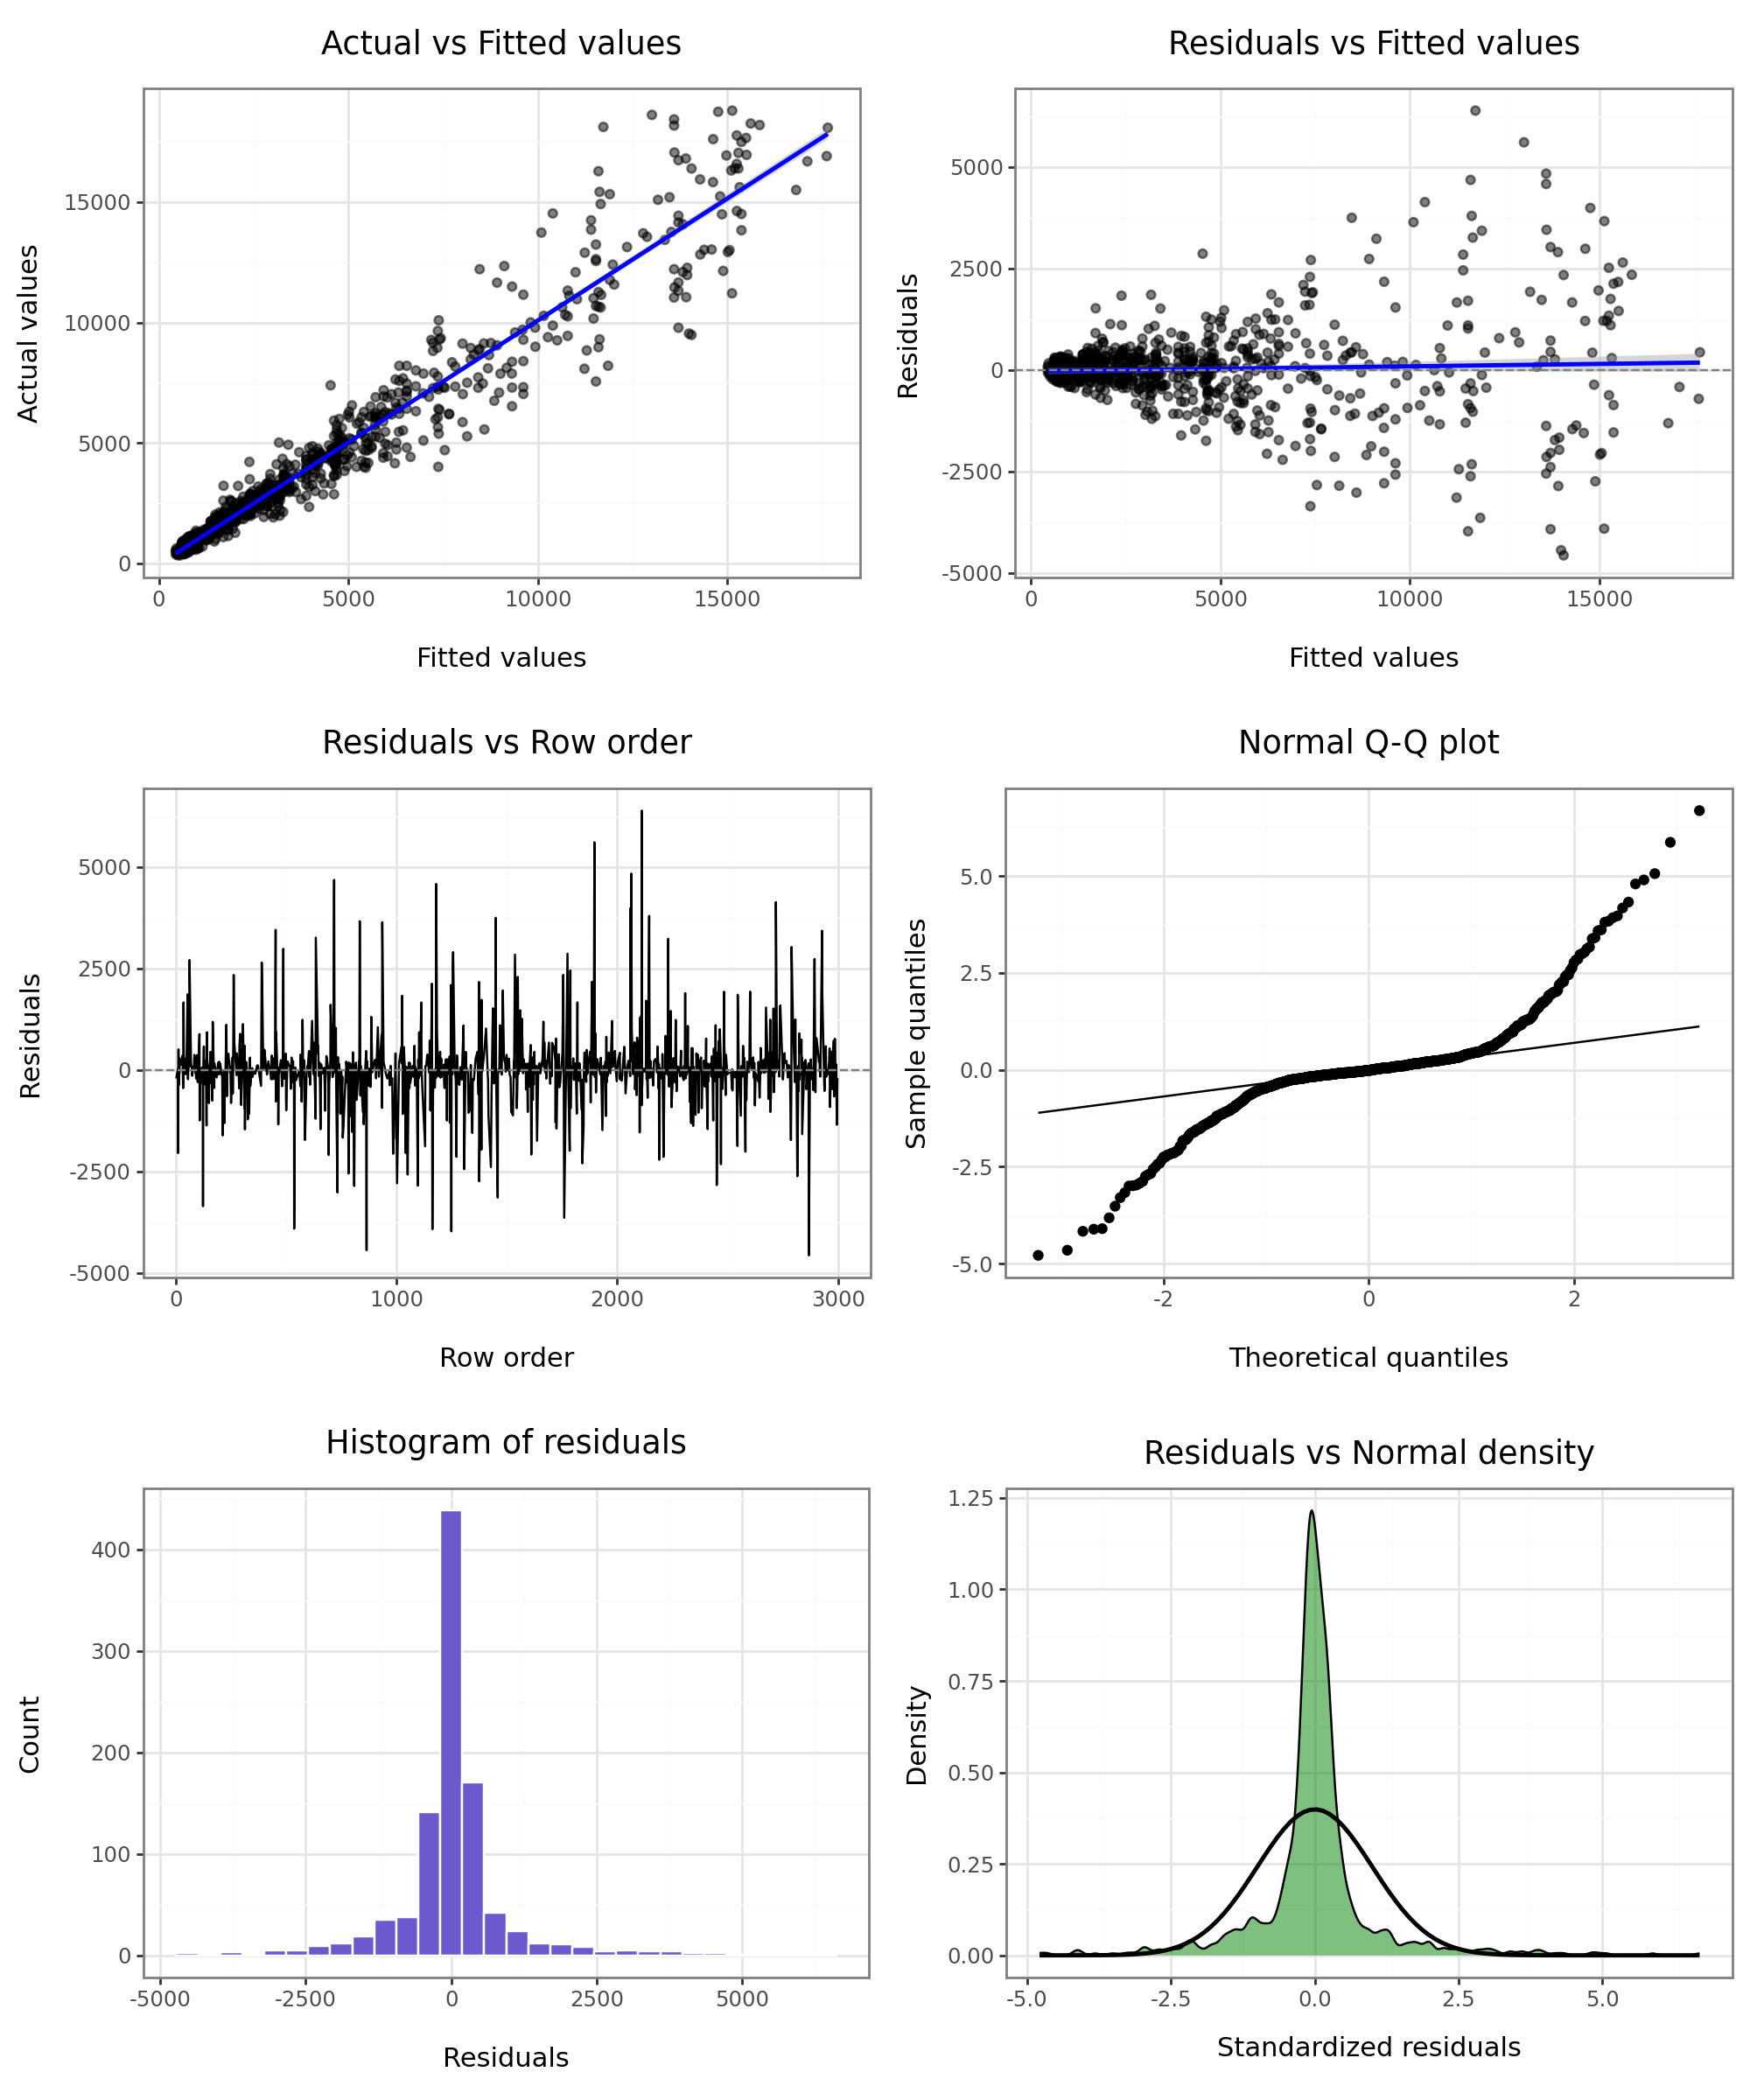

In [18]:
reg_nn.plot("dashboard")

The final diagnostic we will discuss is a set of plots of the residuals versus the explanatory variables (or predictors). The residuals fan-out from left to right in the plot of residuals vs carats. The scatter plot of `clarity` versus residuals shows outliers with strong negative values for lower levels of `clarity` and outliers with strong positive values for diamonds with higher levels of `clarity`.

In [19]:
diamonds = diamonds.with_columns(price_ln=pl.col("price").log(), carat_ln=pl.col("carat").log())

In [20]:
reg_nn = rsm.model.mlp(
    {"diamonds": diamonds}, rvar="price_ln", evar=["carat_ln", "clarity"], mod_type="regression"
)
reg_nn.summary()

Multi-layer Perceptron (NN)
Data                 : diamonds
Response variable    : price_ln
Explanatory variables: carat_ln, clarity
Model type           : regression
Nr. of features      : (2, 8)
Nr. of weights       : 51
Nr. of observations  : 3,000
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
     n     r2    mse    mae
  3000  0.971  0.029  0.135

Raw data             :
shape: (5, 2)
┌───────────┬─────────┐
│ carat_ln  ┆ clarity │
│ ---       ┆ ---     │
│ f64       ┆ cat     │
╞═══════════╪═════════╡
│ -1.139434 ┆ VS1     │
│ -1.07881  ┆ SI1     │
│ -1.203973 ┆ VS2     │
│ -1.049822 ┆ VVS2    │
│ -0.916291 ┆ VS2     │
└───────────┴─────────┘

Estimation data      :
shape: (5, 8)
┌───────────┬────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬──────────

We will apply a (natural) log (or ln) transformation to both price and carat and rerun the analysis to see if the log-log specification is more appropriate for the available data. This transformation can be done in Data > Transform. Select the variables price and carat. Choose Transform from the Transformation type drop-down and choose Ln (natural log) from the Apply function drop-down. Make sure to click the Store button so the new variables are added to the dataset. Note that we cannot apply a log transformation to clarity because it is a categorical variable.

Specify `price_ln` as the response variable and `carat_ln` and `clarity` as the explanatory variables. Before looking at the parameter estimates from the regression lets take a look at the data and residuals. Below are the histograms for the variables in the model. Note that `price_ln` and `carat_ln` are no longer right skewed, a good sign.

The dashboard of six residual plots looks much better than for the linear model. The true values and predicted values from the regression (almost) form a straight line. Although at higher and lower actual and predicted values the line is perhaps still very slightly curved. The residuals are much closer to a random scatter around a horizontal line. The Residual vs Row order plot still looks perfectly straight indicating that auto-correlation is not a concern. Finally, the Q-Q plot shows a nice straight and diagonal line, just like we saw for the ideal data in Example 2. Evidence that the residuals are now normally distributed. This conclusion is confirmed by the histogram and density plot of the residuals.

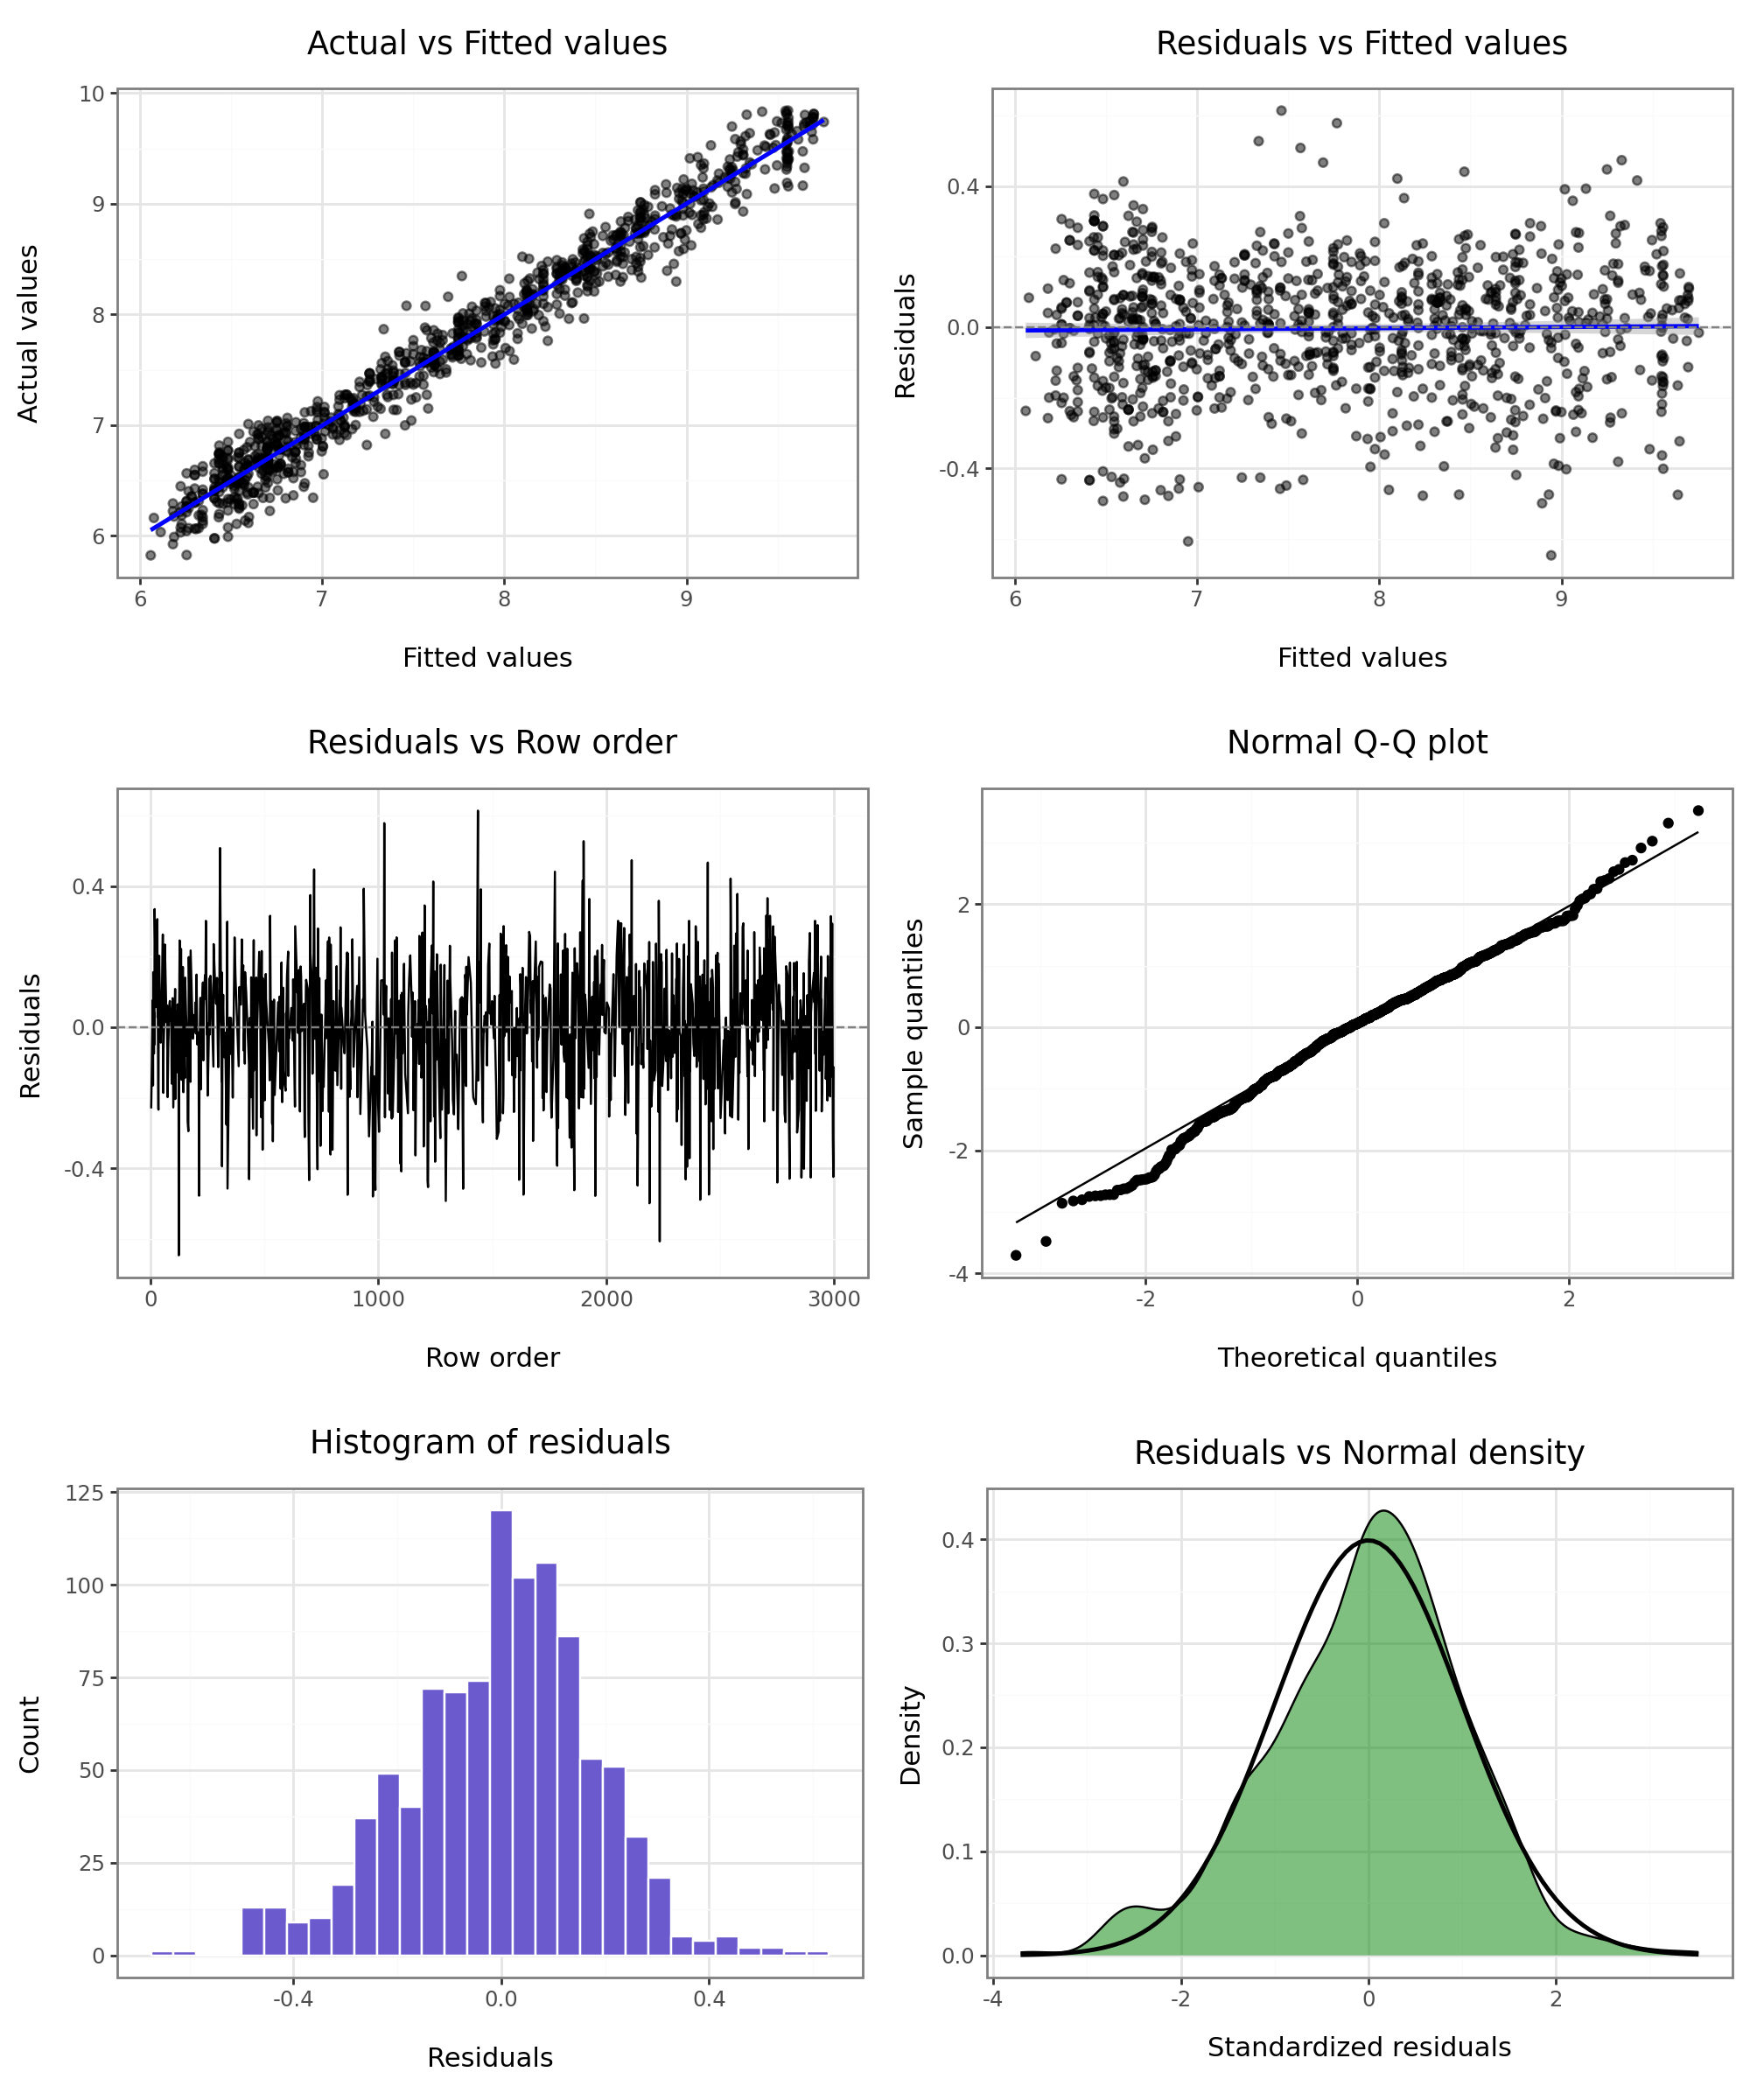

In [21]:
reg_nn.plot("dashboard")

The final diagnostic we will discuss is a set of plots of the residuals versus the explanatory variables (or predictors). The residuals look much closer to random scatter around a horizontal line compared to the linear model. Although for low (high) values of carat_ln the residuals may be a bit higher (lower).

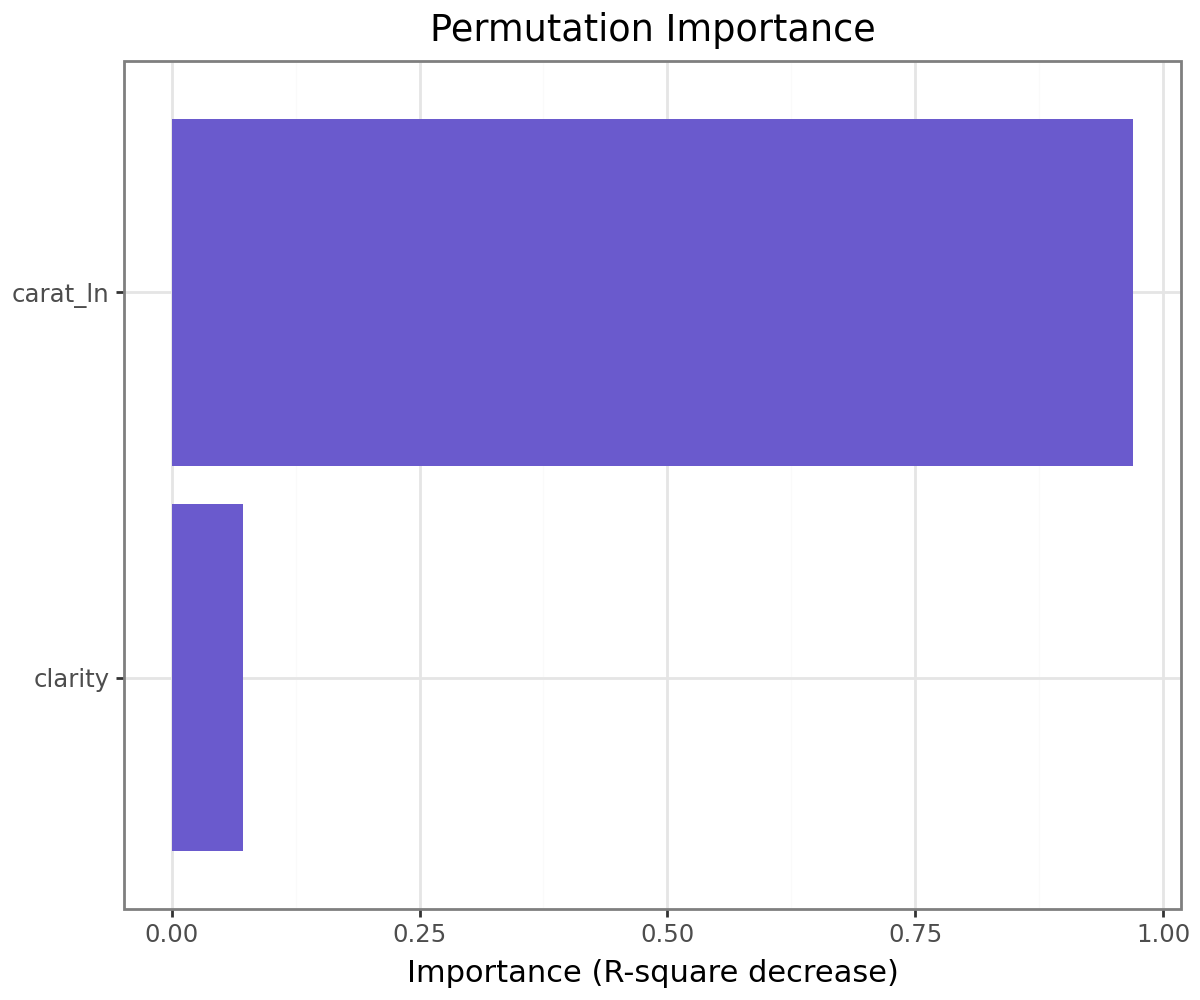

In [22]:
reg_nn.plot("vimp")

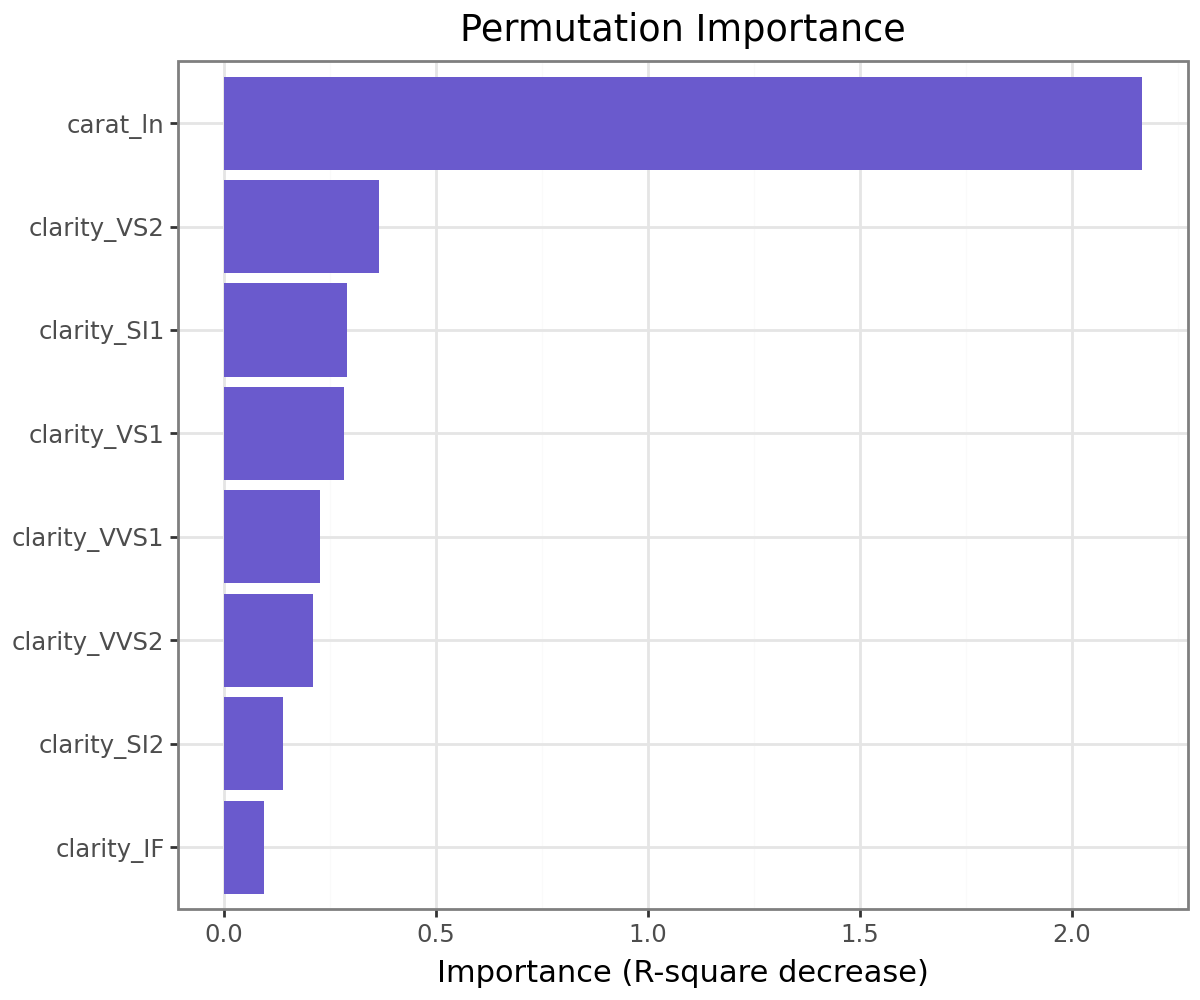

In [23]:
reg_nn.plot("vimp_sklearn")

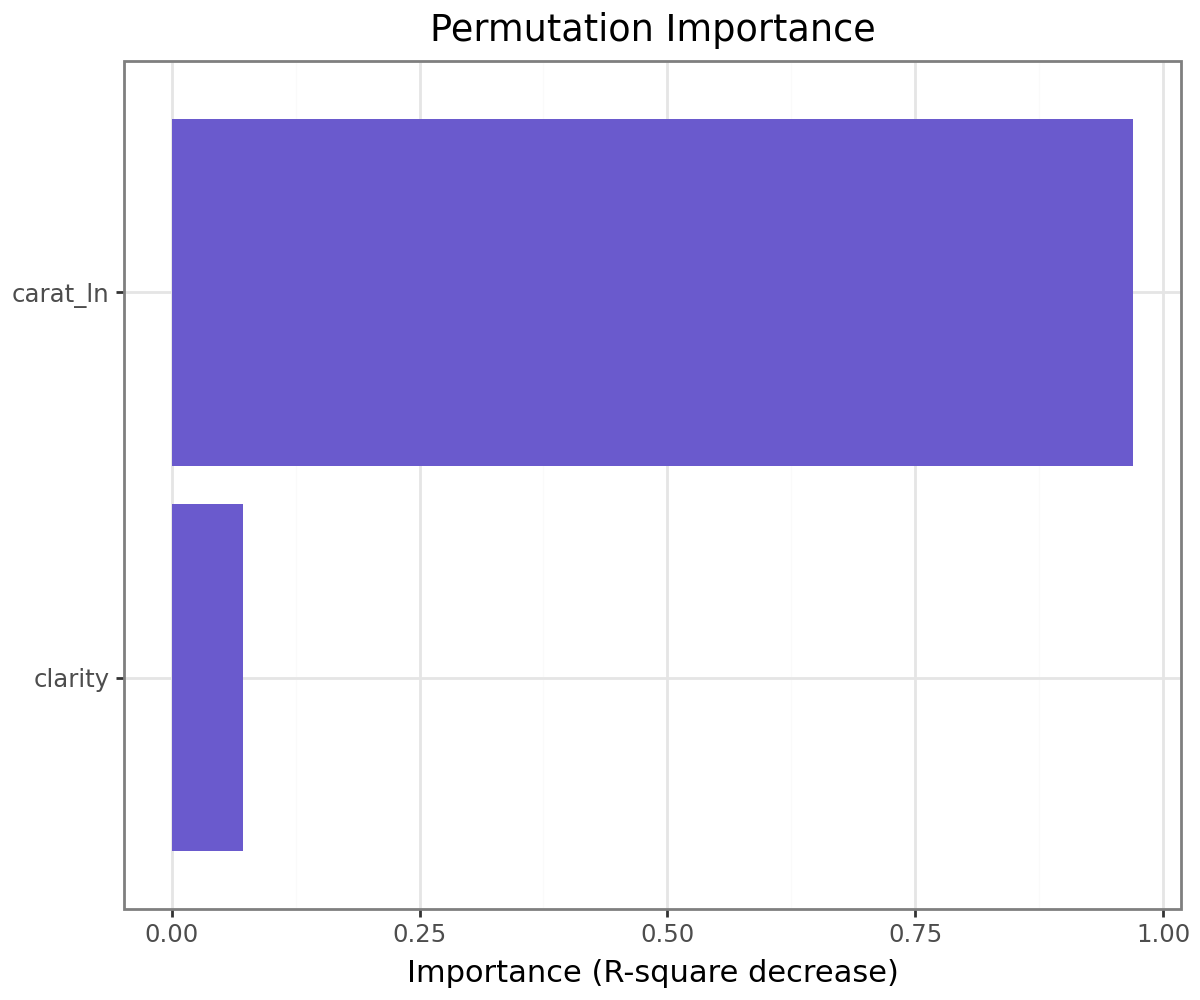

In [24]:
(p, vimp_values) = reg_nn.plot("vimp", ret=True)
p

In [25]:
vimp_values

variable,importance
str,f64
"""carat_ln""",0.969775
"""clarity""",0.071959


In [26]:
reg_nn.predict(dec=3)

carat_ln,clarity,prediction
f64,cat,f64
-1.139,"""VS1""",6.501
-1.079,"""SI1""",6.433
-1.204,"""VS2""",6.436
-1.05,"""VVS2""",6.79
-0.916,"""VS2""",6.885
…,…,…
0.131,"""SI1""",8.651
0.412,"""SI1""",9.093
-1.139,"""VS2""",6.532


# Radiant for Python App

All the output shown above can be reproduced using the Radiant-for-Python web interface. An example of what the code required to start the web interface is shown below. See if you can reproduce the result.

> Note: The app will continue running until you press the `Stop` button in the app navigation bar or the stop button next to the notebook cell

In [27]:
# uncomment the line below if you want to use the radiant web interface
# rsm.radiant.model.mlp({"diamonds": diamonds}, {"diamonds": diamonds_description})

<p align="center">
<img src="figures/mlp-regression-summary.png">
</p>

## Tuning a Neural Network (MLP) model

When building an MLP (Neural Network) model, there are several hyperparameters that can be tuned to improve model performance. Two key parameters we'll focus on are:

- `hidden_layer_sizes`: The number of hidden layers and the number of neurons in each hidden layer
- `alpha`: The regularization parameter (L2 penalty)

To find the optimal combination of these parameters, we'll:

1. Split our data into training (70%) and test (30%) sets
2. Use grid search with 5-fold cross validation to evaluate different parameter combinations
3. Compare model performance with default vs tuned parameters

First, let's create our train/test split:

In [28]:
diamonds = diamonds.with_columns(
    training=rsm.model.make_train(diamonds, test_size=0.3, random_state=1234)
)

In [29]:
reg_nn = rsm.model.mlp(
    data={"diamonds (train)": diamonds.filter(pl.col("training") == 1)},
    rvar="price",
    evar=["carat", "clarity", "cut", "color"],
    mod_type="regression",
)
reg_nn.summary()

Multi-layer Perceptron (NN)
Data                 : diamonds (train)
Response variable    : price
Explanatory variables: carat, clarity, cut, color
Model type           : regression
Nr. of features      : (4, 18)
Nr. of weights       : 101
Nr. of observations  : 2,130
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
     n     r2    mse    mae
  2130  0.982  0.018  0.075

Raw data             :
shape: (5, 4)
┌───────┬─────────┬───────────┬───────┐
│ carat ┆ clarity ┆ cut       ┆ color │
│ ---   ┆ ---     ┆ ---       ┆ ---   │
│ f64   ┆ cat     ┆ cat       ┆ cat   │
╞═══════╪═════════╪═══════════╪═══════╡
│ 0.32  ┆ VS1     ┆ Ideal     ┆ H     │
│ 0.34  ┆ SI1     ┆ Very Good ┆ G     │
│ 0.3   ┆ VS2     ┆ Very Good ┆ G     │
│ 0.4   ┆ VS2     ┆ Premium   ┆ F     │
│ 0.6   ┆ VVS1    ┆ Idea

In [30]:
diamonds = diamonds.with_columns(pred_nn=reg_nn.predict(diamonds).get_column("prediction"))
diamonds

price,carat,clarity,cut,color,depth,table,x,y,z,date,price_ln,carat_ln,training,pred_nn
i32,f64,cat,cat,cat,f64,f64,f64,f64,f64,date,f64,f64,i64,f64
580,0.32,"""VS1""","""Ideal""","""H""",61.0,56.0,4.43,4.45,2.71,2012-02-26,6.363028,-1.139434,1,775.240252
650,0.34,"""SI1""","""Very Good""","""G""",63.4,57.0,4.45,4.42,2.81,2012-02-26,6.476972,-1.07881,1,677.256367
630,0.3,"""VS2""","""Very Good""","""G""",63.1,58.0,4.27,4.23,2.68,2012-02-26,6.44572,-1.203973,1,669.976224
706,0.35,"""VVS2""","""Ideal""","""H""",59.2,56.0,4.6,4.65,2.74,2012-02-26,6.559615,-1.049822,0,771.888503
1080,0.4,"""VS2""","""Premium""","""F""",62.6,58.0,4.72,4.68,2.94,2012-02-26,6.984716,-0.916291,1,943.118205
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4173,1.14,"""SI1""","""Very Good""","""J""",63.3,55.0,6.6,6.67,4.2,2015-12-01,8.33639,0.131028,1,4409.804775
8396,1.51,"""SI1""","""Ideal""","""I""",61.2,60.0,7.39,7.37,4.52,2015-12-01,9.035511,0.41211,1,8409.871965
449,0.32,"""VS2""","""Premium""","""I""",62.6,58.0,4.37,4.42,2.75,2015-12-01,6.107023,-1.139434,0,563.303354


The initial model used default parameters. Let's evaluate different combinations of parameters using grid search cross validation. We'll try:

- hidden_layer_sizes: 1 to 10 neurons in a single hidden layer
- alpha: regularization parameter from 0.0 to 1.0 (in steps of 0.1)

We'll use the R-squared to evaluate performance:

In [31]:
hls = [(i,) for i in range(1, 11)]
param_grid = {"hidden_layer_sizes": hls, "alpha": np.arange(0.0, 1.1, 0.1)}
scoring = {"r2": "r2"}
param_grid

{'hidden_layer_sizes': [(1,),
  (2,),
  (3,),
  (4,),
  (5,),
  (6,),
  (7,),
  (8,),
  (9,),
  (10,)],
 'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

In [32]:
cv_file = "cv-objects/reg-nn-cross-validation-object.pkl"
if os.path.exists(cv_file):
    cv = rsm.load_state(cv_file)["cv"]
else:
    folds = KFold(n_splits=5, shuffle=True, random_state=1234)
    cv = GridSearchCV(
        reg_nn.fitted,
        param_grid,
        scoring=scoring,
        cv=folds,
        n_jobs=4,
        refit=list(scoring.keys())[0],
        verbose=1,
    ).fit(reg_nn.data_onehot, reg_nn.data.price)
    if not os.path.exists("cv-objects"):
        os.mkdir("cv-objects")
    rsm.save_state({"cv": cv}, cv_file)

AttributeError: 'DataFrame' object has no attribute 'price'

In [ ]:
cv.best_params_

In [ ]:
cv.best_score_

In [ ]:
pd.DataFrame(cv.cv_results_).sort_values("rank_test_r2").head()

After finding the optimal parameters, we can build a new model with these tuned parameters and compare its performance to our original model. Looking at the gains charts for both the training and test sets helps us evaluate overfitting while maintaining good predictive performance.

The cross validation results show that slightly different parameter values perform best with this particular dataset compared to the defaults. This demonstrates the value of parameter tuning, though the magnitude of improvement will vary by application.

In [ ]:
cv.best_params_

In [ ]:
reg_nncv = rsm.model.mlp(
    data={"diamonds (train)": diamonds.filter(pl.col("training") == 1)},
    rvar="price",
    evar=["carat", "clarity", "cut", "color"],
    random_state=1234,
    mod_type="regression",
    **cv.best_params_,
)
reg_nncv.summary()

In [ ]:
diamonds = diamonds.with_columns(
    training=rsm.model.make_train(diamonds, test_size=0.3, random_state=1234)
)

In [ ]:
diamonds = diamonds.with_columns(
    training=rsm.model.make_train(diamonds, test_size=0.3, random_state=1234)
)

In [ ]:
reg_nn = rsm.model.mlp(
    data={"diamonds (train)": diamonds.filter(pl.col("training") == 1)},
    rvar="price",
    evar=["carat", "clarity", "cut", "color"],
    mod_type="regression",
)
reg_nn.summary()

In [ ]:
diamonds = diamonds.with_columns(pred_nn=reg_nn.predict(diamonds).get_column("prediction"))
diamonds

The initial model used default parameters. Let's evaluate different combinations of parameters using grid search cross validation. We'll try:

- hidden_layer_sizes: 1 to 10 neurons in a single hidden layer
- alpha: regularization parameter from 0.0 to 1.0 (in steps of 0.1)

We'll use the R-squared to evaluate performance:

In [ ]:
hls = [(i,) for i in range(1, 11)]
param_grid = {"hidden_layer_sizes": hls, "alpha": np.arange(0.0, 1.1, 0.1)}
scoring = {"r2": "r2"}
param_grid

In [ ]:
cv_file = "cv-objects/reg-nn-cross-validation-object.pkl"
if os.path.exists(cv_file):
    cv = rsm.load_state(cv_file)["cv"]
else:
    folds = KFold(n_splits=5, shuffle=True, random_state=1234)
    cv = GridSearchCV(
        reg_nn.fitted,
        param_grid,
        scoring=scoring,
        cv=folds,
        n_jobs=4,
        refit=list(scoring.keys())[0],
        verbose=1,
    ).fit(reg_nn.data_onehot, reg_nn.data.price)
    if not os.path.exists("cv-objects"):
        os.mkdir("cv-objects")
    rsm.save_state({"cv": cv}, cv_file)

In [ ]:
# same functionality as the cell above but less typing
cv = rsm.model.cross_validation(reg_nn, "reg-nn", param_grid, scoring)

In [ ]:
cv.best_params_

In [ ]:
cv.best_score_

In [ ]:
pd.DataFrame(cv.cv_results_).sort_values("rank_test_r2").head()

After finding the optimal parameters, we can build a new model with these tuned parameters and compare its performance to our original model. Looking at the gains charts for both the training and test sets helps us evaluate overfitting while maintaining good predictive performance.

The cross validation results show that slightly different parameter values perform best with this particular dataset compared to the defaults. This demonstrates the value of parameter tuning, though the magnitude of improvement will vary by application.

In [ ]:
cv.best_params_

In [ ]:
if rsm.__version__ < "1.4.0":
    raise ValueError("Update pyrsm to 1.4.0 or higher")

# cross_validation function simplifies the process of cross-validation
# on pyrsm ml models
# use ?rsm.model.cross_validation for more details
cv = rsm.model.cross_validation(reg_nn, "reg-nn", param_grid)

In [ ]:
reg_nncv = rsm.model.mlp(
    data={"diamonds (train)": diamonds.filter(pl.col("training") == 1)},
    rvar="price",
    evar=["carat", "clarity", "cut", "color"],
    random_state=1234,
    mod_type="regression",
    **cv.best_params_,
)
reg_nncv.summary()

In [ ]:
reg_nn = rsm.model.mlp(
    data={"diamonds (train)": diamonds.filter(pl.col("training") == 1)},
    rvar="price",
    evar=["carat", "clarity", "cut", "color"],
    mod_type="regression",
)
reg_nn.summary()

In [ ]:
diamonds = diamonds.with_columns(pred_nn=reg_nn.predict(diamonds).get_column("prediction"))
diamonds

The initial model used default parameters. Let's evaluate different combinations of parameters using grid search cross validation. We'll try:

- hidden_layer_sizes: 1 to 10 neurons in a single hidden layer
- alpha: regularization parameter from 0.0 to 1.0 (in steps of 0.1)

We'll use the R-squared to evaluate performance:

In [ ]:
hls = [(i,) for i in range(1, 11)]
param_grid = {"hidden_layer_sizes": hls, "alpha": np.arange(0.0, 1.1, 0.1)}
scoring = {"r2": "r2"}
param_grid

In [ ]:
cv_file = "cv-objects/reg-nn-cross-validation-object.pkl"
if os.path.exists(cv_file):
    cv = rsm.load_state(cv_file)["cv"]
else:
    folds = KFold(n_splits=5, shuffle=True, random_state=1234)
    cv = GridSearchCV(
        reg_nn.fitted,
        param_grid,
        scoring=scoring,
        cv=folds,
        n_jobs=4,
        refit=list(scoring.keys())[0],
        verbose=1,
    ).fit(reg_nn.data_onehot, reg_nn.data.price)
    if not os.path.exists("cv-objects"):
        os.mkdir("cv-objects")
    rsm.save_state({"cv": cv}, cv_file)

In [ ]:
cv.best_params_

In [ ]:
cv.best_score_

In [ ]:
pd.DataFrame(cv.cv_results_).sort_values("rank_test_r2").head()

After finding the optimal parameters, we can build a new model with these tuned parameters and compare its performance to our original model. Looking at the gains charts for both the training and test sets helps us evaluate overfitting while maintaining good predictive performance.

The cross validation results show that slightly different parameter values perform best with this particular dataset compared to the defaults. This demonstrates the value of parameter tuning, though the magnitude of improvement will vary by application.

In [ ]:
cv.best_params_

In [ ]:
# cross_validation function simplifies the process of cross-validation
# on pyrsm ml models
# use ?rsm.model.cross_validation for more details
cv = rsm.model.cross_validation(reg_nn, "reg-nn", param_grid)

In [ ]:
reg_nncv = rsm.model.mlp(
    data={"diamonds (train)": diamonds.filter(pl.col("training") == 1)},
    rvar="price",
    evar=["carat", "clarity", "cut", "color"],
    random_state=1234,
    mod_type="regression",
    **cv.best_params_,
)
reg_nncv.summary()